In [15]:
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
sys.path.append('../..')
import torch

In [23]:
from utils import train_from_dataset, MeasurementDataset, make_exp_schedule
from qtools import pauli_exp
from models import MPS

In [28]:
trlosses = np.load("data/trlosses.npy")
vallosses = np.load("data/vallosses.npy")
params = np.load("data/validated_params.npy").item()
with open("data/metadata.json") as f:
    metadata=json.load(f)

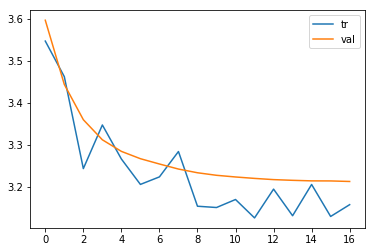

In [8]:
fig, ax = plt.subplots()
plt.plot(trlosses, label="tr")
plt.plot(vallosses, label="val")
plt.legend()

In [21]:
L=4 
fname_settings = "../../datasets/mps_sampled/ghz_plus_L=%d_angles.npy"%L
fname_samples = "../../datasets/mps_sampled/ghz_plus_L=%d_outcomes.npy"%L
Nsamp=20000
samples = np.load(fname_samples)[:Nsamp]
samples_tr = torch.tensor((1-samples)/2).to(dtype=torch.long)
settings = np.load(fname_settings)[:Nsamp]

theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)
U = pauli_exp(theta, phi)
ds = MeasurementDataset(samples=samples_tr,rotations=U)


In [24]:
ground_truth_mps = MPS(L, 2, 2)
ground_truth_mps.load("../../datasets/mps_sampled/ghz_plus_L=%d_state"%L)

In [43]:
lr = make_exp_schedule(params['lr_scale'], params['lr_timescale'])
s2_penalty = make_exp_schedule(params['s2_scale'], params['s2_timescale'])
epochs = 2*len(trlosses)
batch_size = metadata['batch_size']
cutoff=metadata['cutoff']
max_sv_to_keep = metadata['max_sv']




In [44]:
model, logdict = train_from_dataset(ds, lr, batch_size, epochs, 
                                   s2_penalty=s2_penalty, cutoff=cutoff, 
                                   max_sv_to_keep=max_sv_to_keep, ground_truth_mps=ground_truth_mps,
                                   use_cache=True, record_eigs=False,record_s2=True,verbose=True,
                                   early_stopping=True,compute_overlaps=True)

Training on system size 4 with 20000 samples
Finished epoch 0 in 1.023 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]


../../utils.py:746: UserWarning: overlap estimate failed to converge within tolerance 1.00e-02
  warnings.warn("overlap estimate failed to converge within tolerance {0:.2e}".format(eps))


Finished epoch 1 in 1.564 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 2 in 0.728 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 3 in 1.563 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 4 in 0.813 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 5 in 1.257 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 6 in 1.181 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 7 in 1.640 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 8 in 1.638 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 9 in 1.048 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 10 in 1.561 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 11 in 0.814 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 12 in 1.138 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 13 in 0.816 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2,

In [45]:
fidelity_mps = logdict['fidelity_mps']
fidelity_qutip = logdict['fidelity_qutip']
loss = logdict['loss']
max_bond_dim = logdict['max_bond_dim']
eigs = logdict['eigenvalues']
s2 = logdict['s2']
val_loss = logdict['val_loss']
overlap = logdict['overlap']

Text(0.5,1,'batch NLL loss')

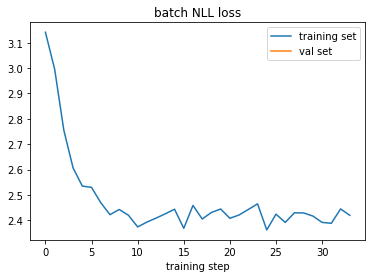

In [46]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(loss, label='training set')
plt.plot(val_loss, label='val set')
plt.legend()
plt.xlabel("training step")
plt.title("batch NLL loss")


Text(0.5,1,'Overlap during training')

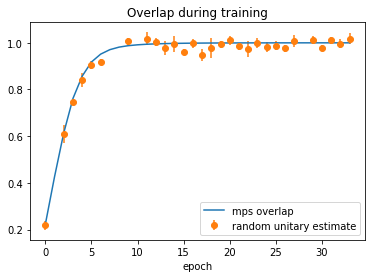

In [47]:
fig, ax = plt.subplots()
plt.plot(range(epochs), fidelity_mps**2, label='mps overlap')

c = overlap['converged']
plt.errorbar(np.arange(epochs)[c], overlap['mean'][c], yerr=overlap['err'][c], marker='o', linestyle='none', 
            label="random unitary estimate")
plt.legend()
plt.xlabel('epoch')
plt.title("Overlap during training")

In [48]:
fidelity_mps

array([0.47049964, 0.65244679, 0.78330935, 0.87253894, 0.92568183,
       0.95774486, 0.97526105, 0.98505123, 0.99055196, 0.9936725 ,
       0.99552567, 0.99675508, 0.99758593, 0.99814056, 0.99854994,
       0.99884518, 0.99908466, 0.99925632, 0.99938087, 0.99947573,
       0.99953548, 0.99959368, 0.99965463, 0.99968476, 0.99969069,
       0.99972381, 0.9997445 , 0.99975958, 0.99977077, 0.99977674,
       0.99978389, 0.99979155, 0.99977634, 0.99977938])